# Exploratory Data Analysis

Statistical functions can be found here: https://nbviewer.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

## Question: What's the average weight of a newborn?

In [2]:
nsfg = pd.read_hdf('data/nsfg.hdf5')
nsfg.head(3)

,caseid,outcome,birthwgt_lb1,birthwgt_oz1,prglngth,nbrnaliv,agecon,agepreg,hpagelb,wgt2013_2015
0,60418,1,5.0,4.0,40,1.0,2000,2075.0,22.0,3554.964843
1,60418,1,4.0,12.0,36,1.0,2291,2358.0,25.0,3554.964843
2,60418,1,5.0,4.0,36,1.0,3241,3308.0,52.0,3554.964843


In [3]:
pounds = nsfg['birthwgt_lb1']
pounds.describe()

count    6485.000000
mean        8.055204
std        11.178893
min         0.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        99.000000
Name: birthwgt_lb1, dtype: float64

In [5]:
# replace 98-99 values since it's not weight
pounds = pounds.replace([98, 99], np.nan)
pounds.describe()

count    6390.000000
mean        6.703286
std         1.429265
min         0.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        17.000000
Name: birthwgt_lb1, dtype: float64

### Clean a variable
In the NSFG dataset, the variable 'nbrnaliv' records the number of babies born alive at the end of a pregnancy.

If you use .value_counts() to view the responses, you'll see that the value 8 appears once, and if you consult the codebook, you'll see that this value indicates that the respondent refused to answer the question.

Your job in this exercise is to replace this value with np.nan. Recall from the video how Allen replaced the values 98 and 99 in the ounces column using the .replace() method:

In [6]:
# Replace the value 8 with NaN
nsfg['nbrnaliv'].replace(8, np.nan, inplace=True)

# Print the values and their frequencies
print(nsfg['nbrnaliv'].value_counts())

1.0    6379
2.0     100
3.0       5
Name: nbrnaliv, dtype: int64


### Calculate pregnancy length
For each pregnancy in the NSFG dataset, the variable 'agecon' encodes the respondent's age at conception, and 'agepreg' the respondent's age at the end of the pregnancy.

Both variables are recorded as integers with two implicit decimal places, so the value 2575 means that the respondent's age was 25.75

In [7]:
# Select the columns and divide by 100
agecon = nsfg['agecon'] / 100
agepreg = nsfg['agepreg'] / 100

# Compute the difference
preg_length = agepreg - agecon

# Compute summary statistics
print(preg_length.describe())

count    9109.000000
mean        0.552069
std         0.271479
min         0.000000
25%         0.250000
50%         0.670000
75%         0.750000
max         0.920000
dtype: float64


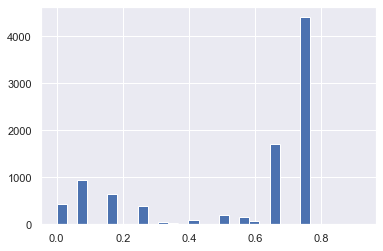

In [12]:
plt.hist(preg_length.dropna(), bins=30)
plt.show()

### Compare the weights in pre-term and normal births

In [17]:
preterm = nsfg['prglngth'] < 37
print('Number of pre-term births:', preterm.sum())

Number of pre-term births: 3742


In [19]:
print('Pre-term mean baby weight:', nsfg[preterm]['birthwgt_lb1'].mean())
print('Normal mean baby weight:', nsfg[~preterm]['birthwgt_lb1'].mean())

Pre-term mean baby weight: 6.8250825082508255
Normal mean baby weight: 8.255738880918221


### Investigate age column

In [21]:
def resample_rows_weighted(df, column='wgt2013_2015'):
    """Resamples a DataFrame using probabilities proportional to given column.
    Args:
        df: DataFrame
        column: string column name to use as weights
    returns: 
        DataFrame
    """
    weights = df[column].copy()
    weights /= sum(weights)
    indices = np.random.choice(df.index, len(df), replace=True, p=weights)
    sample = df.loc[indices]
    return sample

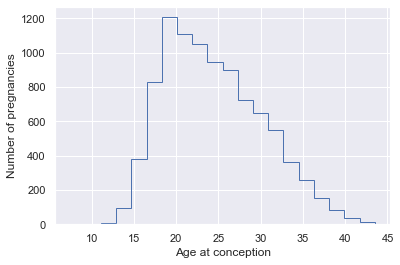

In [20]:
# Plot the histogram
plt.hist(agecon, bins=20, histtype='step')

# Label the axes
plt.xlabel('Age at conception')
plt.ylabel('Number of pregnancies')

# Show the figure
plt.show()

In [22]:
# Resample the data
nsfg = resample_rows_weighted(nsfg, 'wgt2013_2015')

# Clean the weight variables
pounds = nsfg['birthwgt_lb1'].replace([98, 99], np.nan)
ounces = nsfg['birthwgt_oz1'].replace([98, 99], np.nan)

# Compute total birth weight
birth_weight = pounds + ounces/16

In [23]:
# Create a Boolean Series for full-term babies
full_term = nsfg['prglngth'] >= 37

# Select the weights of full-term babies
full_term_weight = birth_weight[full_term]

# Compute the mean weight of full-term babies
print(full_term_weight.mean())

7.414526306434412


In [24]:
# Filter full-term babies
full_term = nsfg['prglngth'] >= 37

# Filter single births
single = nsfg['nbrnaliv'] == 1

# Compute birth weight for single full-term babies
single_full_term_weight = birth_weight[full_term & single]
print('Single full-term mean:', single_full_term_weight.mean())

# Compute birth weight for multiple full-term babies
mult_full_term_weight = birth_weight[full_term & ~single]
print('Multiple full-term mean:', mult_full_term_weight.mean())

Single full-term mean: 7.427415383237823
Multiple full-term mean: 5.700892857142857


## Distributions

In [26]:
gss = pd.read_hdf('data/gss.hdf5', 'gss')
gss.head(3)

,year,age,cohort,sex,race,educ,realinc,gunlaw,grass,wtssall
0,1972,26.0,1946.0,1,1,18.0,13537.0,2.0,NaN,0.8893
1,1972,38.0,1934.0,2,1,12.0,18951.0,1.0,NaN,0.4446
2,1972,57.0,1915.0,1,1,12.0,30458.0,1.0,NaN,1.3339


In [48]:
def pdf(df, col, normalize=False):
    df2 = df.copy()
    
    if not normalize:
        return df2[col].value_counts().sort_index()
    
    N = 10000
    outcomes = np.zeros(N)
    for i in range(N):
        outcome = np.random.choice(df[col])
        outcomes[i] = outcome

    val, cnt = np.unique(outcomes, return_counts=True)
    prop = cnt / len(outcomes)
    return pd.DataFrame({'index': val, 'probability': prop}).dropna()
    

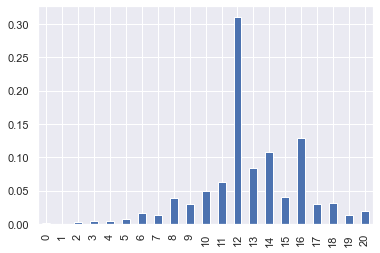

In [55]:
educ_pdf = pdf(gss, 'educ', normalize=True)
educ_pdf.probability.plot(kind='bar')
plt.show()

In [56]:
!pip install empiricaldist

  Preparing metadata (setup.py) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.6.2-py3-none-any.whl size=10733 sha256=1acc32a7d8abe4a2e5ed5477792bd45b7db9b7f26d3356185ca5cf35dda72a82
  Stored in directory: /home/repl/.cache/pip/wheels/2a/ed/75/39cda0596e8f5606df54fb63969c565b49d23869ee64a62435
Successfully built empiricaldist


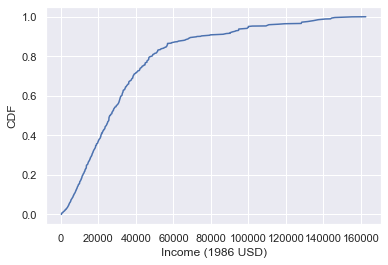

In [58]:
import empiricaldist

# Select realinc
income = gss['realinc']

# Make the CDF
cdf_income = empiricaldist.Cdf.from_seq(income)

# Plot it
cdf_income.plot()

# Label the axes
plt.xlabel('Income (1986 USD)')
plt.ylabel('CDF')
plt.show()

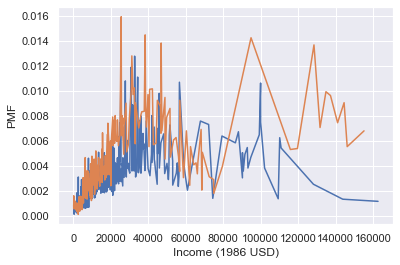

In [63]:
income = gss['realinc']
pre95 = gss['year'] < 1995

empiricaldist.Pmf.from_seq(income[pre95]).plot(label='Before 1995')
empiricaldist.Pmf.from_seq(income[~pre95]).plot(label='After 1995')
plt.xlabel('Income (1986 USD)')
plt.ylabel('PMF')
plt.show()

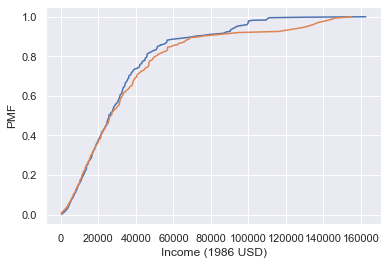

In [64]:
income = gss['realinc']
pre95 = gss['year'] < 1995

empiricaldist.Cdf.from_seq(income[pre95]).plot(label='Before 1995')
empiricaldist.Cdf.from_seq(income[~pre95]).plot(label='After 1995')
plt.xlabel('Income (1986 USD)')
plt.ylabel('PMF')
plt.show()

In [68]:
# Select educ
educ = gss['educ']

# Bachelor's degree
bach = (educ >= 16)

# Associate degree
assc = ((educ >= 14) & (educ < 16))

# High school (12 or fewer years of education)
high = (educ <= 12)
print(high.mean())

0.5308807991547402


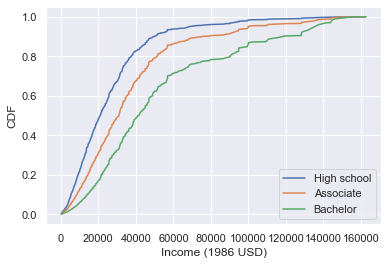

In [69]:
income = gss['realinc']

# Plot the CDFs
empiricaldist.Cdf.from_seq(income[high]).plot(label='High school')
empiricaldist.Cdf.from_seq(income[assc]).plot(label='Associate')
empiricaldist.Cdf.from_seq(income[bach]).plot(label='Bachelor')

# Label the axes
plt.xlabel('Income (1986 USD)')
plt.ylabel('CDF')
plt.legend()
plt.show()

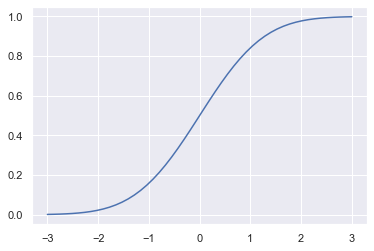

In [72]:
# normal CDF 
from scipy.stats import norm

xs = np.linspace(-3, 3)
ys = norm(0, 1).cdf(xs)

plt.plot(xs, ys)
plt.show()

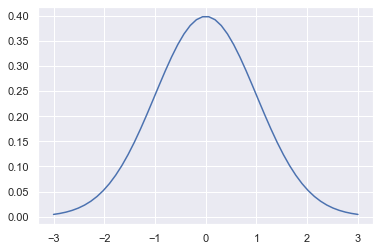

In [73]:
xs = np.linspace(-3, 3)
ys = norm(0, 1).pdf(xs)

plt.plot(xs, ys)
plt.show()

In [74]:
# Extract realinc and compute its log
income = gss['realinc']
log_income = np.log10(income)

# Compute mean and standard deviation
mean = np.mean(log_income)
std = np.std(log_income)
print(mean, std)

# Make a norm object
from scipy.stats import norm
dist = norm(mean, std)

4.371148677934171 0.42900437330100427


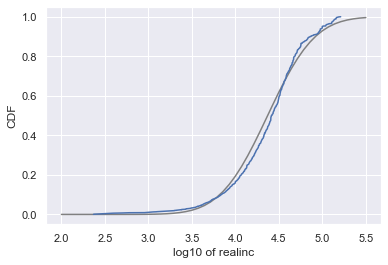

In [76]:
# Evaluate the model CDF
xs = np.linspace(2, 5.5)
ys = dist.cdf(xs)

# Plot the model CDF
plt.clf()
plt.plot(xs, ys, color='gray')

# Create and plot the Cdf of log_income
empiricaldist.Cdf.from_seq(log_income).plot()
    
# Label the axes
plt.xlabel('log10 of realinc')
plt.ylabel('CDF')
plt.show()

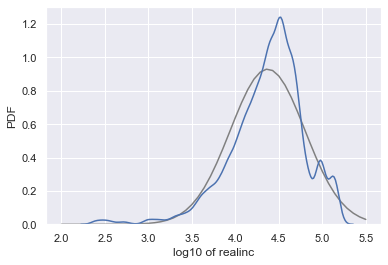

In [77]:
# Evaluate the normal PDF
xs = np.linspace(2, 5.5)
ys = dist.pdf(xs)

# Plot the model PDF
plt.clf()
plt.plot(xs, ys, color='gray')

# Plot the data KDE
sns.kdeplot(log_income)

# Label the axes
plt.xlabel('log10 of realinc')
plt.ylabel('PDF')
plt.show()